In [13]:
!pip install pandas
!pip install seaborn
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import pandas as pd

In [15]:
df = pd.read_csv('./kafka/6k_data_notifications.csv')
print(df.head())
print(len(df))

                        _id      createdAt  receivedByConsumerAt  \
0  66a25a8acc231e36bb374e80  1721916042643         1721916042595   
1  66a25a8bcc231e36bb374e81  1721916043179         1721916043179   
2  66a25a8bcc231e36bb374e82  1721916043186         1721916043185   
3  66a25a8bcc231e36bb374e83  1721916043194         1721916043193   
4  66a25a8bcc231e36bb374e84  1721916043204         1721916043204   

   sentFromBrokerAt  updatedAt  
0     1721916041956          0  
1     1721916041955          0  
2     1721916041955          0  
3     1721916041956          0  
4     1721916041955          0  
5757095


In [16]:
# Convert columns to integer type if needed
df['receivedByConsumerAt'] = pd.to_numeric(df['receivedByConsumerAt'], errors='coerce')
df['sentFromBrokerAt'] = pd.to_numeric(df['sentFromBrokerAt'], errors='coerce')

In [17]:
df['e2eLatency'] = df['receivedByConsumerAt'] - df['sentFromBrokerAt']

In [18]:
print(df.head())

                        _id      createdAt  receivedByConsumerAt  \
0  66a25a8acc231e36bb374e80  1721916042643         1721916042595   
1  66a25a8bcc231e36bb374e81  1721916043179         1721916043179   
2  66a25a8bcc231e36bb374e82  1721916043186         1721916043185   
3  66a25a8bcc231e36bb374e83  1721916043194         1721916043193   
4  66a25a8bcc231e36bb374e84  1721916043204         1721916043204   

   sentFromBrokerAt  updatedAt  e2eLatency  
0     1721916041956          0         639  
1     1721916041955          0        1224  
2     1721916041955          0        1230  
3     1721916041956          0        1237  
4     1721916041955          0        1249  


In [ ]:
df.to_csv('data_6k_kafka_with_latency.csv', index=False)

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
df_sorted = df.sort_values(by='e2eLatency').reset_index(drop=True)
len(df_sorted)

percentiles = df_sorted['e2eLatency'].quantile([0.50, 0.70, 0.90, 0.95, 0.99])
print(percentiles)

0.50    1656574.0
0.70    2204810.0
0.90    2449112.0
0.95    2475627.0
0.99    2486733.0
Name: e2eLatency, dtype: float64


In [22]:
import numpy as np

print("panjang ", len(df))

# Fungsi untuk menghitung persentil dengan interpolasi
def calculate_percentile(df, percentile):
    n = len(df)
    position = percentile * (n + 1) / 100
    
    if position.is_integer():
        return df['e2eLatency'].iloc[int(position) - 1], position
    else:
        lower_index = int(np.floor(position)) - 1
        upper_index = int(np.ceil(position)) - 1
        lower_value = df['e2eLatency'].iloc[lower_index]
        upper_value = df['e2eLatency'].iloc[upper_index]
        interpolated_value = lower_value + (position - lower_index - 1) * (upper_value - lower_value)
        return interpolated_value, position

# Persentil yang akan dihitung
percentiles = [50, 70, 90, 95, 99]

# Tampilkan perhitungan manual untuk setiap persentil
for p in percentiles:
    value, position = calculate_percentile(df_sorted, p)
    if position > len(df_sorted):
        value = df_sorted['e2eLatency'].iloc[-1]  # Nilai terbesar jika posisi melebihi jumlah data
    print(f"Percentil ke-{p}:")
    print(f"Posisi = {p}% x (n + 1) / 100 = {position}")
    if position.is_integer():
        print(f"Nilai pada posisi {int(position)} adalah {value} ms")
    else:
        lower_index = int(np.floor(position))
        upper_index = int(np.ceil(position))
        lower_value = df_sorted['e2eLatency'].iloc[lower_index - 1]
        upper_value = df_sorted['e2eLatency'].iloc[upper_index - 1]
        print(f"Interpolasi antara nilai ke-{lower_index} ({lower_value} ms) dan ke-{upper_index} ({upper_value} ms):")
        print(f"Persentil ke-{p} = {lower_value} + ({position - lower_index}) x ({upper_value} - {lower_value}) = {value} ms")
    print()

panjang  5757095
Percentil ke-50:
Posisi = 50% x (n + 1) / 100 = 2878548.0
Nilai pada posisi 2878548 adalah 1656574 ms

Percentil ke-70:
Posisi = 70% x (n + 1) / 100 = 4029967.2
Interpolasi antara nilai ke-4029967 (2204810 ms) dan ke-4029968 (2204810 ms):
Persentil ke-70 = 2204810 + (0.20000000018626451) x (2204810 - 2204810) = 2204810.0 ms

Percentil ke-90:
Posisi = 90% x (n + 1) / 100 = 5181386.4
Interpolasi antara nilai ke-5181386 (2449112 ms) dan ke-5181387 (2449113 ms):
Persentil ke-90 = 2449112 + (0.40000000037252903) x (2449113 - 2449112) = 2449112.4000000004 ms

Percentil ke-95:
Posisi = 95% x (n + 1) / 100 = 5469241.2
Interpolasi antara nilai ke-5469241 (2475627 ms) dan ke-5469242 (2475627 ms):
Persentil ke-95 = 2475627 + (0.20000000018626451) x (2475627 - 2475627) = 2475627.0 ms

Percentil ke-99:
Posisi = 99% x (n + 1) / 100 = 5699525.04
Interpolasi antara nilai ke-5699525 (2486733 ms) dan ke-5699526 (2486733 ms):
Persentil ke-99 = 2486733 + (0.0400000000372529) x (2486733 - 

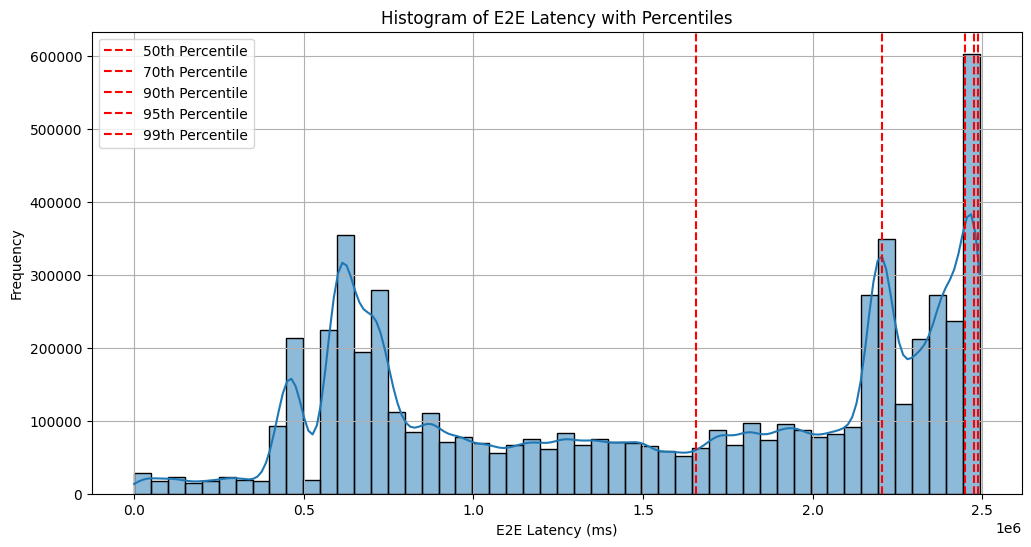

In [47]:
plt.figure(figsize=(12, 6))
sns.histplot(df_sorted['e2eLatency'], bins=50, kde=True)

# Tambahkan garis vertikal untuk persentil
for p in [0.50, 0.70, 0.90, 0.95, 0.99]:
    plt.axvline(percentiles[p], color='r', linestyle='--', label=f'{int(p*100)}th Percentile')

plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())

plt.title('Histogram of E2E Latency with Percentiles')
plt.xlabel('E2E Latency (ms)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

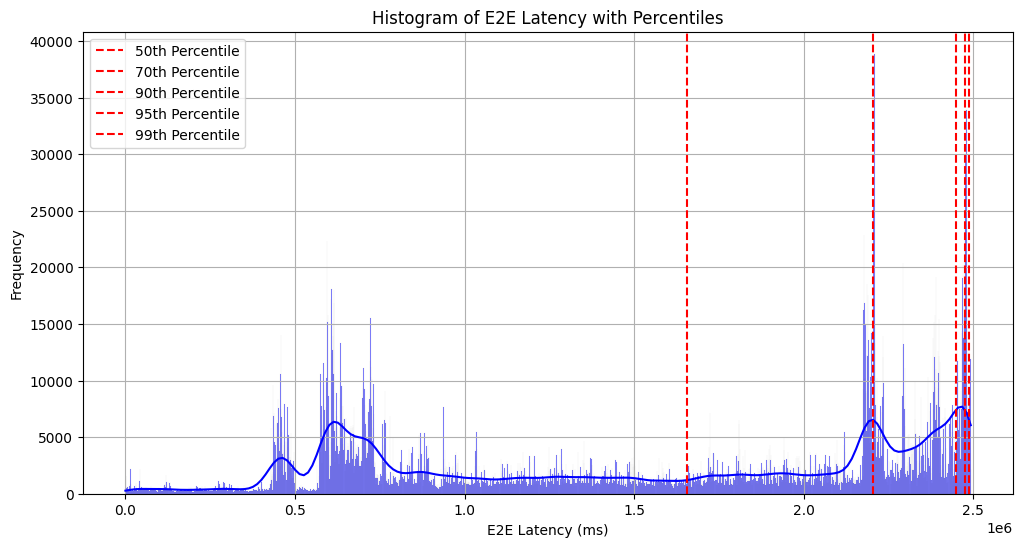

In [45]:
# Tentukan rentang bin
min_latency = df_sorted['e2eLatency'].min()
max_latency = df_sorted['e2eLatency'].max()
bin_range = range(int(min_latency), int(max_latency) + 1000, 1000)

# Visualisasikan histogram
plt.figure(figsize=(12, 6))
sns.histplot(df_sorted['e2eLatency'], bins=bin_range, kde=True, color='blue')

# Tambahkan garis vertikal untuk persentil
for p in [0.50, 0.70, 0.90, 0.95, 0.99]:
    plt.axvline(percentiles[p], color='r', linestyle='--', label=f'{int(p*100)}th Percentile')

plt.title('Histogram of E2E Latency with Percentiles')
plt.xlabel('E2E Latency (ms)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
start_time_ms = 1721916037695
end_time_ms = 1721956081046
data_received_mongo = 5757095
#data_received_postgres = 5757095 
#data_loss_nats = 0

# Hitung total waktu pengujian dalam milidetik
total_time_ms = end_time_ms - start_time_ms

# Konversi total waktu ke detik
total_time_seconds = total_time_ms / 1000

# Hitung throughput
throughput = data_received_mongo / total_time_seconds


# Konversi total waktu ke jam
total_time_hours = total_time_seconds / 3600

# Konversi total waktu ke menit
total_time_minutes = total_time_seconds / 60

# Tampilkan hasil
print(f"Total waktu pengujian milish : {total_time_ms: .3f}")
print(f"Total waktu pengujian: {total_time_seconds:.3f} detik ({total_time_hours:.3f} jam) ({total_time_minutes:.3f} menit)")
print(f"Total event yang diproses: {data_received_mongo}")
print(f"Throughput: {throughput:.2f} events/second")

Total waktu pengujian milish :  40043351.000
Total waktu pengujian: 40043.351 detik (11.123 jam) (667.389 menit)
Total event yang diproses: 5757095
Throughput: 143.77 events/second


In [18]:
# using actual data from csv

start_time_ms = df['sentFromBrokerAt'].min()
end_time_ms = df['receivedByConsumerAt'].max()
data_received_mongo = len(df)

print("start time ms ", start_time_ms)
print("start time ms ", end_time_ms)
print("data received mongo ", data_received_mongo)

# Hitung total waktu pengujian dalam milidetik
total_time_ms = end_time_ms - start_time_ms

print("total time ms ", total_time_ms)

# Konversi total waktu ke detik
total_time_seconds = total_time_ms / 1000
print("total waktu detik ", total_time_seconds)

# Hitung throughput
throughput = data_received_mongo / total_time_seconds


# Konversi total waktu ke jam
total_time_hours = total_time_seconds / 3600

# Konversi total waktu ke menit
total_time_minutes = total_time_seconds / 60

# Tampilkan hasil
print(f"Total waktu pengujian milish : {total_time_ms: .3f}")
print(f"Total waktu pengujian: {total_time_seconds:.3f} detik ({total_time_hours:.3f} jam) ({total_time_minutes:.3f} menit)")
print(f"Total event yang diproses: {data_received_mongo}")
print(f"Throughput: {throughput:.2f} events/second")

start time ms  1721916041955
start time ms  1721956763542
data received mongo  5757095
total time ms  40721587
total waktu detik  40721.587
Total waktu pengujian milish :  40721587.000
Total waktu pengujian: 40721.587 detik (11.312 jam) (678.693 menit)
Total event yang diproses: 5757095
Throughput: 141.38 events/second
